# Exercicios 1 e 2 de Redes Neurais Artificiais 

**Ramon Gomes Durães de Oliveira | 2019720188** 

*Agosto de 2019*



**Nota: O exercício foi feito utilizando Jupyter Notebook, entretanto percebi que ao exportar para PDF o arquivo ficou enorme (não tem como esconder código e há muito espaço em branco quando não cabe algum gráfico. Farei os próximos exercícios no R Sweave ou R Markdown para diminuir o tamanho!**

## Problema 1 - a) Dados linearmente separáveis

In [1]:
rm(list=ls())
library("mlbench")
library("caret")
library("e1071")

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


### Gerando a base de dados

Serão gerados 100 pontos para duas classes de dados bidimensionais linearmente separáveis utilizando a distribuição normal: 

In [2]:
n1 <- 100
mu1 <- c(1,1)
sd1 <- 0.4
xc1 <- cbind(rnorm(n = n1, mean = mu1[1], sd = sd1),
             rnorm(n = n1, mean = mu1[2], sd = sd1),
            0)

n2 <- 100
mu2 <- c(3,3)
sd2 <- 0.4
xc2 <- cbind(rnorm(n = n2, mean = mu2[1], sd = sd2),
             rnorm(n = n2, mean = mu2[2], sd = sd2), 
             1)

data <- data.frame(rbind(xc1, xc2))
colnames(data) <- c("x1", "x2", "class")
head(data)

x1,x2,class
0.9140179,1.6153671,0
1.2329000,0.4751506,0
1.0636019,1.2390148,0
1.1831255,1.1937495,0
1.2373763,0.6219856,0
1.2202838,1.9121248,0


Visualizando:

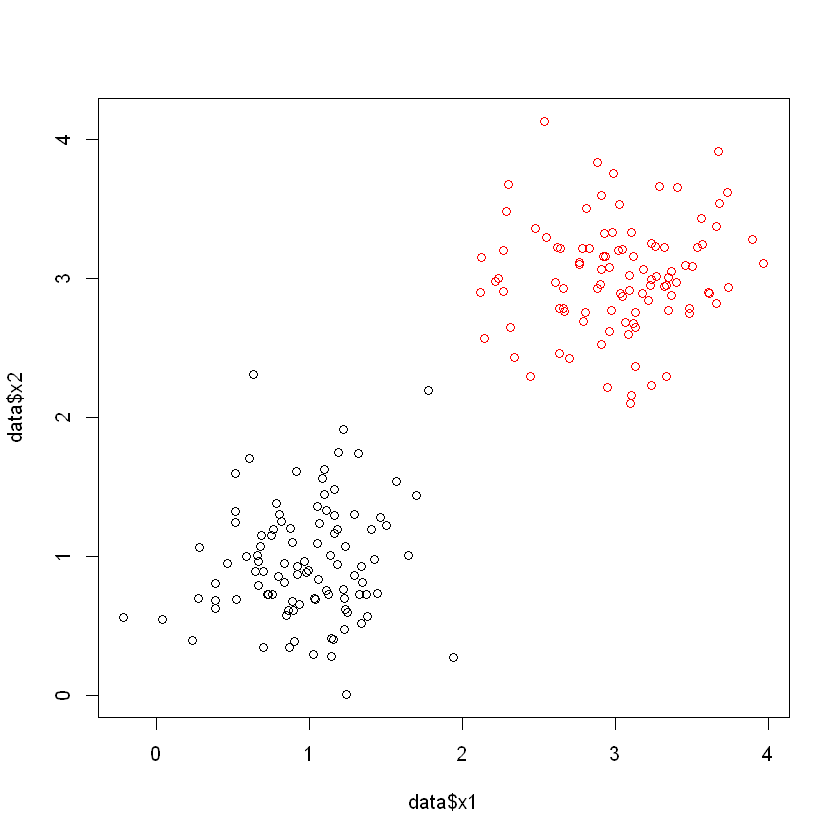

In [3]:
plot(data$x1, data$x2, col=data$class + 1)

### Implementação do Perceptron

Foi implementada uma função de treinamento de um perceptron simples, que toma como entradas:
- data: os dados de entrada no formato de matriz do R na qual o número de linhas é o número de observações. A coluna de 1's ou -1's (a bias unit) já deve ter sido adicionada aos dados e a classe (y) está na última coluna;
- eta: a taxa de aprendizado;
- tol: a tolerância de erro (uma das condições de parada);
- nepochs: o número de épocas de treinamento (caso o erro não fique menor que tol);
- shuffle_data (opcional): se verdadeiro (T) embaralha os dados antes de treinar.

A função inicializa um vetor de pesos aleatório $W$ e, para cada observação $x_i$, calcula a saída $\hat{y}_i$ e a compara com a saída real $y_i$. Se a classe prevista for diferente da real, o vetor de pesos é atualizado seguindo a regra:

\begin{equation}
W=W + \eta * e_i * x_i
\end{equation}

O erro é acumulado para cada época e comparado com $tol$. A função então retorna os pesos ajustados $W$ e o erro acumulado a cada época de treinamento.

In [4]:
train_perceptron <- function(data, 
                             eta, 
                             tol,
                             nepochs,
                             shuffle_data = T){
# This function assumes the bias term has already 
# been added if necessary and the classes of each 
# observation are in the last column of the input data.
    
    nrows <- dim(data)[1] 
    ndims <- dim(data)[2] - 1
    error_vec <- matrix(0, nrow=1, ncol=nepochs)

    # Randomly initializes weight vector
    W <- as.matrix(runif(ndims, -1, 1), nrow=ndims, ncol=1)
    
    for (epoch in 1:nepochs){
        
        # Shuffles data
        if(shuffle_data){
            data_seq <- data[sample(nrows),]
        } else {
            data_seq <- data
        }

        # Loops over data
        for(row in 1:nrows){
            
            xi <- t(data_seq[row,1:ndims])
            yi <- data_seq[row, ndims+1]
            
            # Calculates yhat
            yhat <- 1.0 * as.numeric(xi %*% W >= 0 )
            # Compares with true y
            error <- as.vector(yi - yhat)
#             cat(sprintf("%i %i %i\n", yi, yhat, error))
            # Adjusts weight vector
            dw <- t(eta * error * xi)
            W <- W + dw
            # Accumulates error
            error_vec[epoch] <- error_vec[epoch] + abs(error) 
        }
        
        # Stopping criteria: error smaller than tolerance
        if (error_vec[epoch] < tol){
            print("Stopping due to error smaller than tol.")
            break
        }
    }
    return(list("weights" = W, "errors" = error_vec))
}


### Aplicando nos dados gerados

Utilizando os parâmetros mostrados no código abaixo, um perceptron foi treinado para os dados gerados. Os pesos e o erro por época de treinamento também são mostrados abaixo

In [7]:
tol <- 0.00001
eta <- 0.01
nepochs <- 10
shuffle_data <- T
data_aug <- data.matrix(cbind(-1,data))

perceptron <- train_perceptron(data = data_aug, 
                             eta = eta, 
                             tol = tol,
                             nepochs = nepochs,
                             shuffle_data = shuffle_data)
perceptron

[1] "Stopping due to error smaller than tol."


$weights
         [,1]
-1 0.28778089
x1 0.03612347
x2 0.09383918

$errors
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]  101   38   14    6    2    3    0    0    0     0

Avaliando a saída do perceptron num grid de pontos, pode-se plotar a superfície de separação gerada:

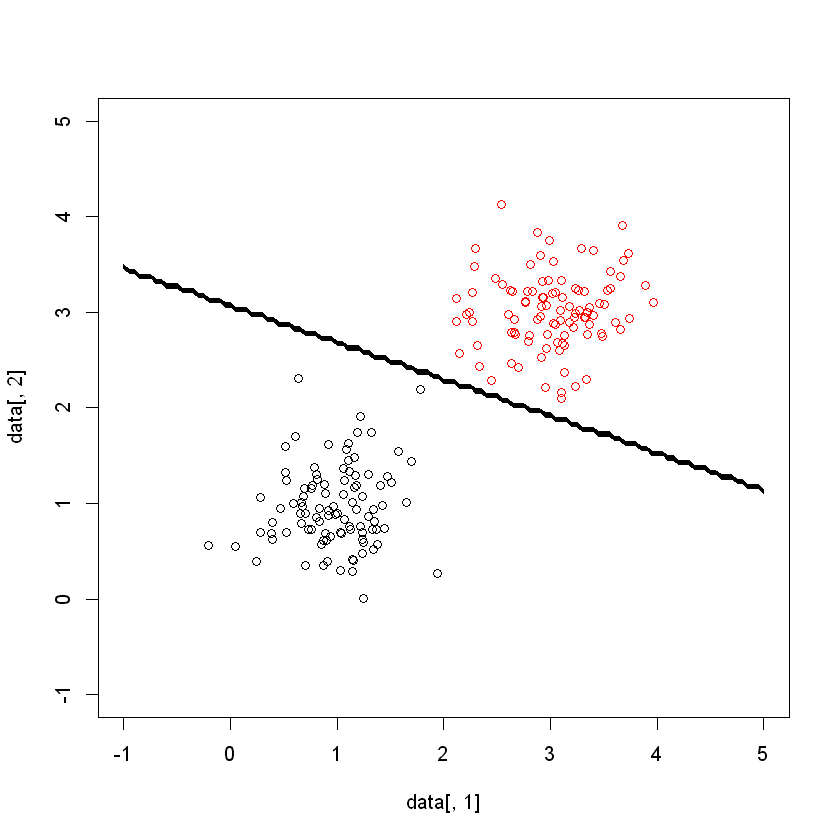

In [8]:
# Plotting surface
xseq <- seq(-1,5,0.05)
lseq <- length(xseq)
MZ <- matrix(0, nrow=lseq, ncol=lseq)

for(i in 1:lseq){
    for(j in 1:lseq){
        xi <- as.matrix(cbind(-1, xseq[i], xseq[j]), nrow = 1, ncol=ndims)
        MZ[i,j] <- 1.0 * (xi %*% perceptron$weights >= 0 )
    }
}

lim=c(-1,5)
plot(data[,1], data[,2], col=data[,3]+1, xlim=lim, ylim=lim)
par(new=T)
contour(x= xseq, y=xseq, z=MZ, xlim=lim, ylim=lim, lwd=0.5, drawlabels = F)

Percebe-se que esta é uma das infinitas retas que separam os dados gerados, mas não é a de margem máxima.

Para avaliar o perceptron em novas entradas e analisar os resultados da classificação, foi criada a função **evaluate_perceptron** que recebe como entrada:
- perceptron: um perceptron treinado, do qual os pesos são extraídos;
- data: os novos dados nos quais o perceptron será avaliado, no mesmo formato anterior;

A saída desta função é:

- $\hat{y}$: o vetor de classes preditas para cada observação de entrada;
- error: o erro percentual de classificação
- confusionMatrix: a matriz de confução (e métricas como sensibilidade e especificidade da classificação).

In [9]:
evaluate_perceptron <- function(perceptron, data){
    nrows <- dim(data)[1] 
    ndims <- dim(data)[2] - 1
    yhat_vec <- matrix(ncol= 1, nrow = nrows)
    W <- as.matrix(perceptron$weights)
    
    # Loops over data
    for(row in 1:nrows){

        xi <- t(data[row,1:ndims])
        yi <- data[row, ndims+1]

        # Calculates yhat
        yhat_vec[row] <- 1.0 * (xi %*% W >= 0 )
    }
    
    confMat <- confusionMatrix(as.factor(yhat_vec), as.factor(data[,ncol(data)]))
    error <- 100 * sum(yhat_vec != data[,ndims+1]) / nrows
    
    return(list("yhat" = yhat_vec, 
                "error" = error,
                "confusionMatrix" = confMat))
}

Aplicando esta função nos dados gerados, obtem-se:

In [10]:
results <- evaluate_perceptron(perceptron, data_aug)
results$confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 100   0
         1   0 100
                                     
               Accuracy : 1          
                 95% CI : (0.9817, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : 0          
                                     

Para este problema hipotético, todas as métricas de classificação são perfeitas!

## Problema 1 - b) Breast Cancer

Abaixo é carregada a base de dados Breast Cancer do pacote mlbench. A tarefa é separar cânceres de mama benignos dos malignos.

In [11]:
data(BreastCancer)
head(BreastCancer)

Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
1000025,5,1,1,1,2,1,3,1,1,benign
1002945,5,4,4,5,7,10,3,2,1,benign
1015425,3,1,1,1,2,2,3,1,1,benign
1016277,6,8,8,1,3,4,3,7,1,benign
1017023,4,1,1,3,2,1,3,1,1,benign
1017122,8,10,10,8,7,10,9,7,1,malignant


Abaixo os dados são preparados para classificação:
- A coluna "ID" é removida;
- A coluna -1 (bias unit) é adicionada;
- As classes são codificadas de forma que "malign" torna-se a classe positiva (1) e benign 0.

In [12]:
# Removing Id and Class
bc <- BreastCancer[,!names(BreastCancer) %in% c("Id", "Class")]
# Defining benign as 0 as malign as 1
class <- 1 * (BreastCancer$Class == "benign")
# Adding -1 column and numeric class
bc <- cbind(-1, bc, class)
# Removing NA
bc <- bc[complete.cases(bc), ]
# Converting to numeric matrix
bc <- data.matrix(bc)
head(bc)

# 1.0 * (BreastCancer$Class == "benign")

-1,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,class
-1,5,1,1,1,2,1,3,1,1,1
-1,5,4,4,5,7,10,3,2,1,1
-1,3,1,1,1,2,2,3,1,1,1
-1,6,8,8,1,3,4,3,7,1,1
-1,4,1,1,3,2,1,3,1,1,1
-1,8,10,10,8,7,10,9,7,1,0


Aplicando o treinamento do perceptron utilizando os parâmetros do código abaixo, obtemos:

In [101]:
tol <- 0.0001
eta <- 0.001
nepochs <- 30
shuffle_data <- T

bc_perceptron <- train_perceptron(data = bc, 
                             eta = eta, 
                             tol = tol,
                             nepochs = nepochs,
                             shuffle_data = shuffle_data)
bc_perceptron

$weights
                        [,1]
-1              -1.021738879
Cl.thickness    -0.058421924
Cell.size       -0.001106742
Cell.shape      -0.031576689
Marg.adhesion   -0.048860668
Epith.c.size    -0.009378182
Bare.nuclei     -0.040717107
Bl.cromatin     -0.041798865
Normal.nucleoli -0.013210643
Mitoses         -0.082633144

$errors
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
[1,]  290  148   96   69   60   46   36   32   30    34    28    29    27    29
     [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24] [,25] [,26]
[1,]    25    26    29    24    24    22    24    26    24    26    24    22
     [,27] [,28] [,29] [,30]
[1,]    19    22    26    27

Para avaliar o perceptron treinado nos dados e analisar as métricas de classificação, utilizamos a funçao "evaluate perceptron".

In [102]:
bc_results <- evaluate_perceptron(bc_perceptron, data.matrix(bc[,1:ncol(bc)]))
bc_results$error

[1] 2.489019

O erro de classificação obtido foi de 2,49% para toda a base de dados. Abaixo estão a matriz de confusão e as demais métricas:

In [103]:
bc_results$confusionMatrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 233  11
         1   6 433
                                          
               Accuracy : 0.9751          
                 95% CI : (0.9604, 0.9854)
    No Information Rate : 0.6501          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9456          
                                          
 Mcnemar's Test P-Value : 0.332           
                                          
            Sensitivity : 0.9749          
            Specificity : 0.9752          
         Pos Pred Value : 0.9549          
         Neg Pred Value : 0.9863          
             Prevalence : 0.3499          
         Detection Rate : 0.3411          
   Detection Prevalence : 0.3572          
      Balanced Accuracy : 0.9751          
                                          
       'Positive' Class : 0               
                              

Destaca-se as seguintes métricas:
- Acurácia : 0.9751. Indica o percentual de acerto da classificação.
- Sensibilidade : 0.9749. Indica a capacidade do classificador de classificar como doentes pacientes efetivamente doentes. No caso, acertar o diagnóstico de pacientes que de fato têm um câncer de mama maligno.
- Especificidade: 0.9752. Neste caso, esta métrica indica a capacidade do teste de classificar como não-doentes (no caso, com câncer de mama benigno) os pacientes de fato têm um câncer benigno.

Percebe-se, também pela matriz de confusão mostrada acima, que o classificador errou um total de 17 observações: 11 falsos negativos e 6 falsos positivos.

## Problema 2 - a) Dados lineares com ruído gaussiano

In [104]:
rm(list=ls())

### Gerando os dados

Para gerar os dados, serão utilizados os parâmetros abaixo:

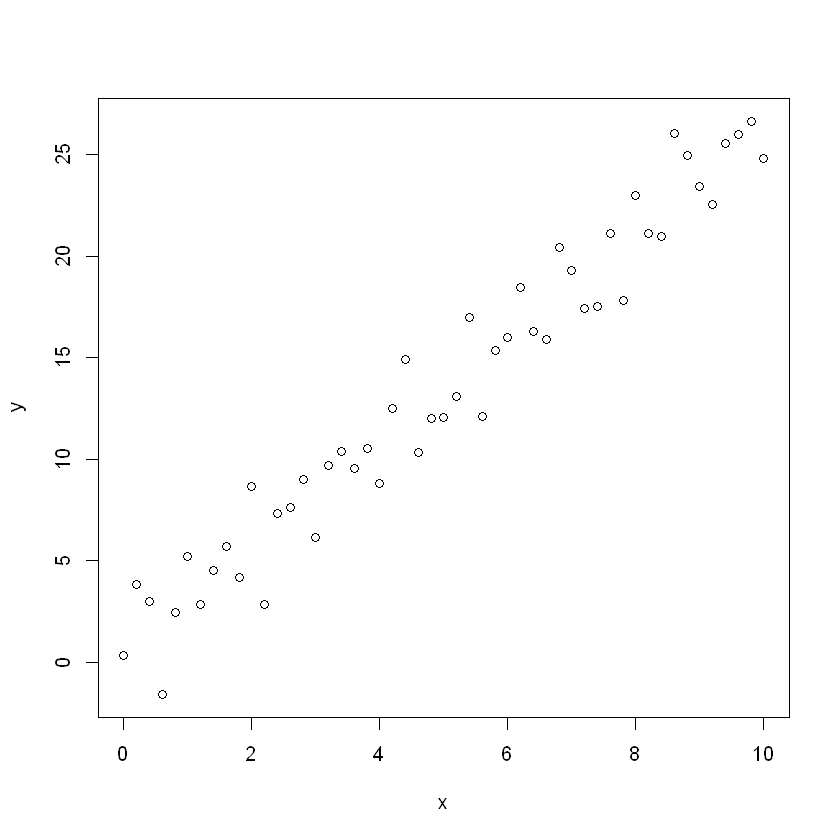

In [105]:
x <- seq(0,10,0.2)
a <- 2.5
b <- 1
sd <- 2
y <- a * x + b + rnorm(length(x), sd = sd)
plot(x, y)

### Implementação do Adaline

Como no caso do Perceptron, foi implementada uma função de treinamento para o Adaline. Por ser extremamente similar à função de treinamento do Perceptron, ela não será detalhada. Destaca-se somente a utilização da função identidade como ativação do neurônio, que culmina no cálculo de $\hat{y}$ seguindo a equação:
\begin{equation}
\hat{y} = \sum w_i x_i
\end{equation}

In [106]:
train_adaline <- function(data, 
                          eta, 
                          tol,
                          nepochs,
                          shuffle_data = T){
# This function assumes the bias term has already 
# been added if necessary and the classes of each 
# observation are in the last column of the input data.
    
    nrows <- dim(data)[1] 
    ndims <- dim(data)[2]-1
    error_vec <- matrix(0, nrow=1, ncol=nepochs)

    # Randomly initializes weight vector
    W <- as.matrix(runif(ndims, -1, 1), nrow=ndims, ncol=1)
    
    for (epoch in 1:nepochs){
        
        # Shuffles data
        if(shuffle_data){
            data_seq <- data[sample(nrows),]
        } else {
            data_seq <- data
        }

        # Loops over data
        for(row in 1:nrows){
            
            xi <- t(data_seq[row,1:ndims])
            yi <- data_seq[row, ndims+1]
            
            # Calculates yhat
            yhat <- xi %*% W
            # Compares with true y
            error <- as.vector(yi - yhat)
#             cat(sprintf("%i %i %i\n", yi, yhat, error))
            # Adjusts weight vector
            dw <- t(eta * error * xi)
            W <- W + dw
            # Accumulates error
            error_vec[epoch] <- error_vec[epoch] + abs(error) 
        }
        
        # Stopping criteria: error smaller than tolerance
        if (error_vec[epoch] < tol){
            print("Stopping due to error smaller than tol.")
            break
        }
    }
    return(list("weights" = W, "errors" = error_vec))
}


Para avaliar o adaline em novas entradas e analisar os resultados da regressão, foi criada a função evaluate_adaline, que também é similar à evaluate_perceptron mas retorna o erro quadrático médio ao invés das métricas de classificação.

In [107]:
evaluate_adaline <- function(adaline, data){
# This function assumes the bias term has already 
# been added if necessary and the classes of each 
# observation are in the last column of the input data.
    
    nrows <- dim(data)[1] 
    ndims <- dim(data)[2] -1 

    # Randomly initializes weight vector
    W <- adaline$weights
    yhat_vec <- matrix(nrow=nrow(data))
    # Loops over data
    for(row in 1:nrows){

        xi <- t(data[row, 1:ndims])
        # Calculates yhat
        yhat_vec[row] <- xi %*% W
    }
    
    mse = mean((yhat_vec - data[,ndims+1])^2) 
    
    return(list("yhat" = yhat_vec, "mse" = mse))
}


Aplicando as funções de treinamento e avaliação nos dados gerados, obtém-se a seguinte reta:

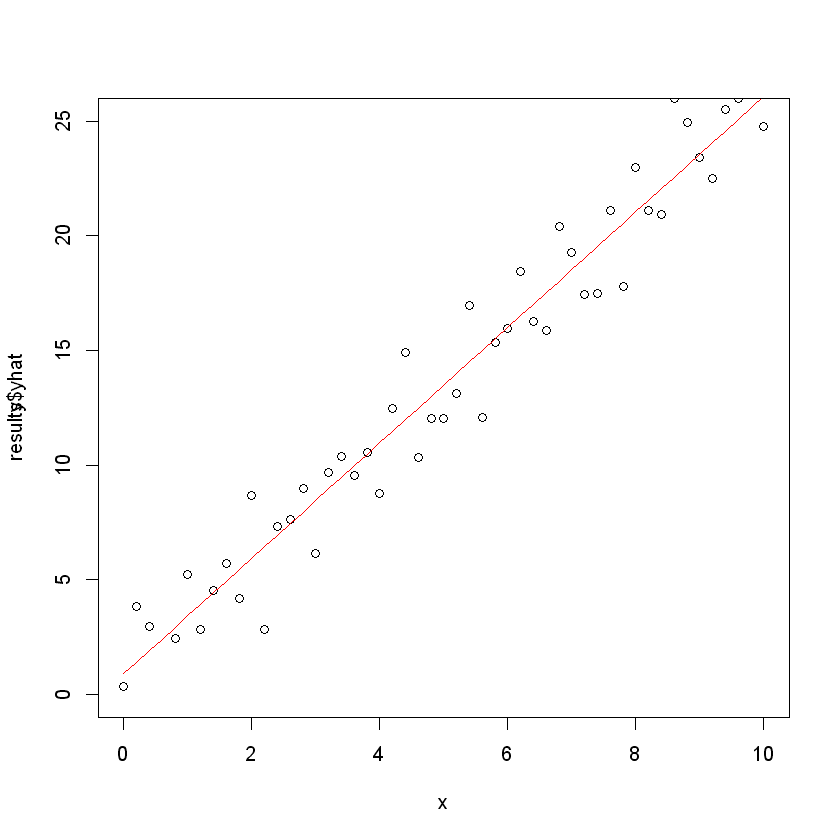

In [108]:
adaline = train_adaline(data=data.matrix(cbind(1, x, y)),
             eta = 0.001,
             tol = 0.0001,
             nepochs = 20)

results <- evaluate_adaline(adaline, cbind(1,x,y))
plot(x,y, xlim=c(0,10), ylim=c(0,25))
par(new=T)
plot(x,results$yhat, type='l', col='red', xlim=c(0,10), ylim=c(0,25))

E o ero quadrático médio:

In [109]:
results$mse

[1] 2.987494

### Comparando o erro quadrático médio e a variância do ruído com o aumento do número de pontos

In [113]:
a <- 2.5
b <- 1
sd <- 2

length_vec <- as.vector(c(10, 50, 100, 500, 1000, 5000))
l <- length(length_vec)
mse_vec <- matrix(0, nrow = 1, ncol = l)

for (i in 1:l) {
    x <- seq(0,10,length=length_vec[i])
    y <- a * x + b + rnorm(length(x), sd = sd)
    adaline_exp = train_adaline(data=data.matrix(cbind(1, x, y)),
             eta = 0.001,
             tol = 0.0001,
             nepochs = 20)

    results_exp <- evaluate_adaline(adaline_exp, cbind(1,x,y))
    mse_vec[i] <- results_exp$mse
}

In [114]:
df <- data.frame("Length" = as.integer(length_vec), "Error" = as.vector(mse_vec))
t(df)

Length,10.000000,50.000000,100.000000,500.000000,1000.000000,5000.000000
Error,4.214544,2.316156,4.174968,4.053985,3.929347,3.954323


Percebe-se que o erro quadrático médio se aproxima muito, e mais consistentemente, da variância do ruído com o aumento do número de pontos! No caso com mais pontos (5.000) o erro quadrático médio foi 3.95 enquanto a variância do ruído é de $sd^2=2^2=4$.

## Exercicio 2 - b) Building

Carregando e visualizando os dados fornecidos (base de dados Building):

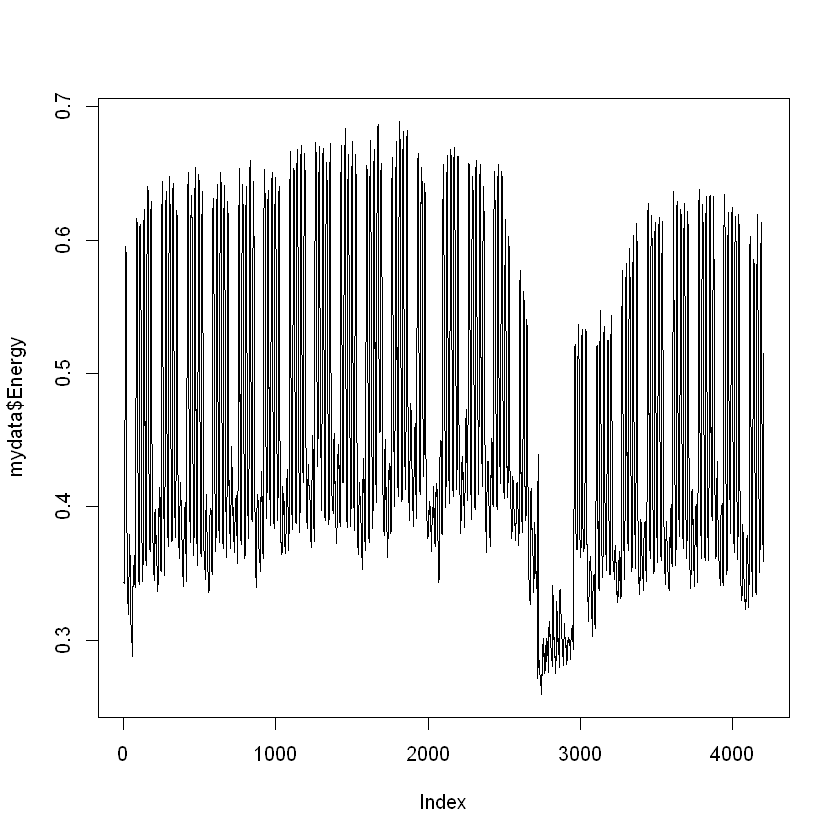

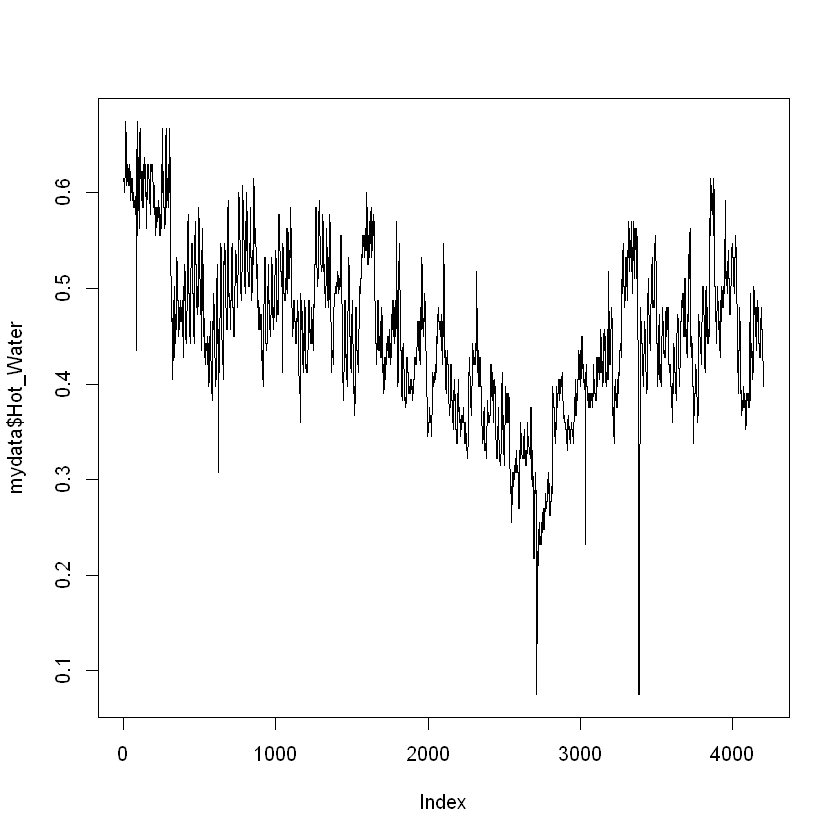

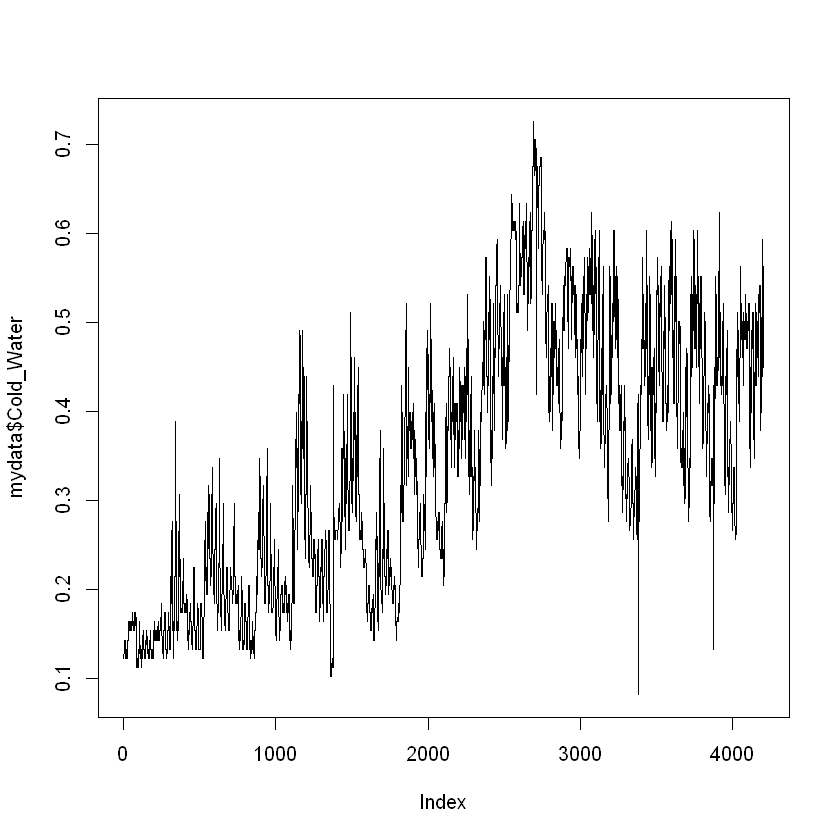

In [115]:
#  Training data 
#  14 coded inputs :
#    MONTH  DAY  YEAR  HOUR  TEMP  HUMID  SOLAR  WIND  WBE  WBCW  WBHW
#  3 outputs (Consumption of) :
#    Electrical Energy Hot Water Cold Water
# bool_in=0
# real_in=14
# bool_out=0
# real_out=3
# training_examples=2104
# validation_examples=1052
# test_examples=1052

mydata = read.csv("BUILDING1paraR.DT", sep=" ")

plot(mydata$Energy,type="l")
plot(mydata$Hot_Water,type="l")
plot(mydata$Cold_Water,type="l")

In [116]:
head(mydata)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Energy,Hot_Water,Cold_Water
1,0,0,0,0,0,0,0.833333,-0.826087,1,0.819,0.736,0.00943396,0.272143,0.343433,0.6150,0.122727
1,0,0,0,0,0,0,0.750000,-0.739130,1,0.807,0.748,0.00943396,0.283571,0.344118,0.6075,0.132955
1,0,0,0,0,0,0,0.666667,-0.652174,1,0.797,0.776,0.00943396,0.275714,0.343848,0.6075,0.132955
1,0,0,0,0,0,0,0.583333,-0.565217,1,0.790,0.788,0.00952830,0.217143,0.342374,0.6075,0.143182
1,0,0,0,0,0,0,0.500000,-0.478261,1,0.789,0.796,0.00952830,0.202857,0.344832,0.6000,0.143182
1,0,0,0,0,0,0,0.416667,-0.391304,1,0.785,0.808,0.00990566,0.138214,0.357895,0.6000,0.143182


Percebe-se que há 14 variáveis de entrada e 3 saídas. Elas serão separadas para serem preditas individualmente e a coluna de 1's (bias unit) será adicionada.

In [117]:
# Removing Output variables
building_data <- mydata[,!names(mydata) %in% c("Energy", "Hot_Water", "Cold_Water")]
# Adding 1 column and numeric class
building_data <- cbind(1, building_data)
# Converting to numeric matrix
building_data <- data.matrix(building_data)
head(building_data)

1,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
1,1,0,0,0,0,0,0,0.833333,-0.826087,1,0.819,0.736,0.00943396,0.272143
1,1,0,0,0,0,0,0,0.750000,-0.739130,1,0.807,0.748,0.00943396,0.283571
1,1,0,0,0,0,0,0,0.666667,-0.652174,1,0.797,0.776,0.00943396,0.275714
1,1,0,0,0,0,0,0,0.583333,-0.565217,1,0.790,0.788,0.00952830,0.217143
1,1,0,0,0,0,0,0,0.500000,-0.478261,1,0.789,0.796,0.00952830,0.202857
1,1,0,0,0,0,0,0,0.416667,-0.391304,1,0.785,0.808,0.00990566,0.138214


### Treinando e Avaliando:

Abaixo estão os parâmetros de treinamento e resultados para cada uma das saídas. Os gráficos mostram o erro em cada época e a função aproximada. Para melhor visualização, apenas um trecho da predição foi plotado pois há muitos pontos na base de dados.

#### 1) Energy

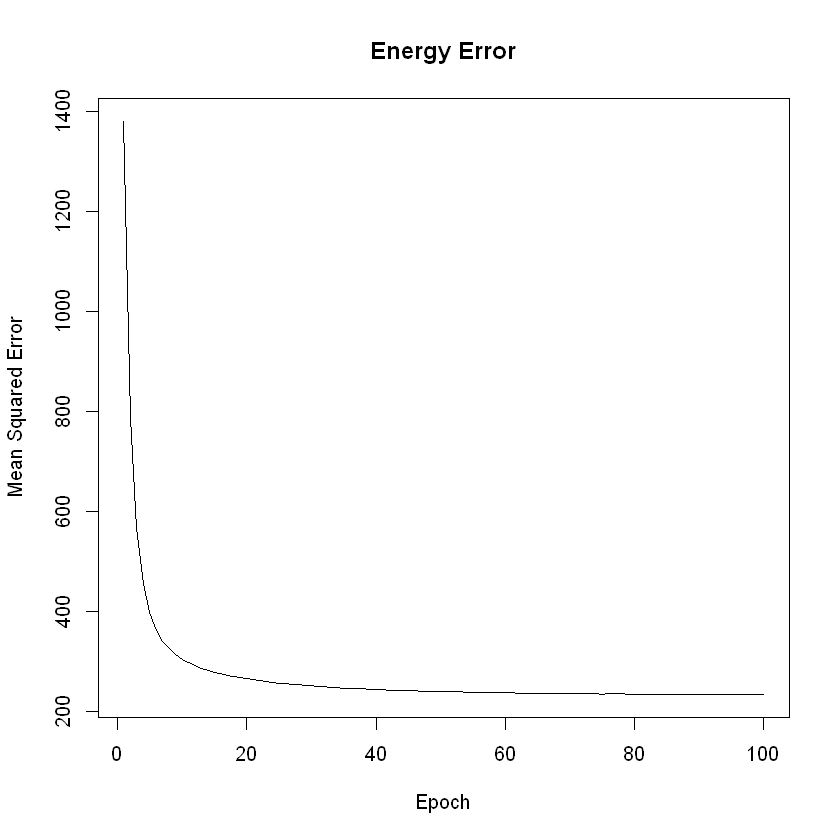

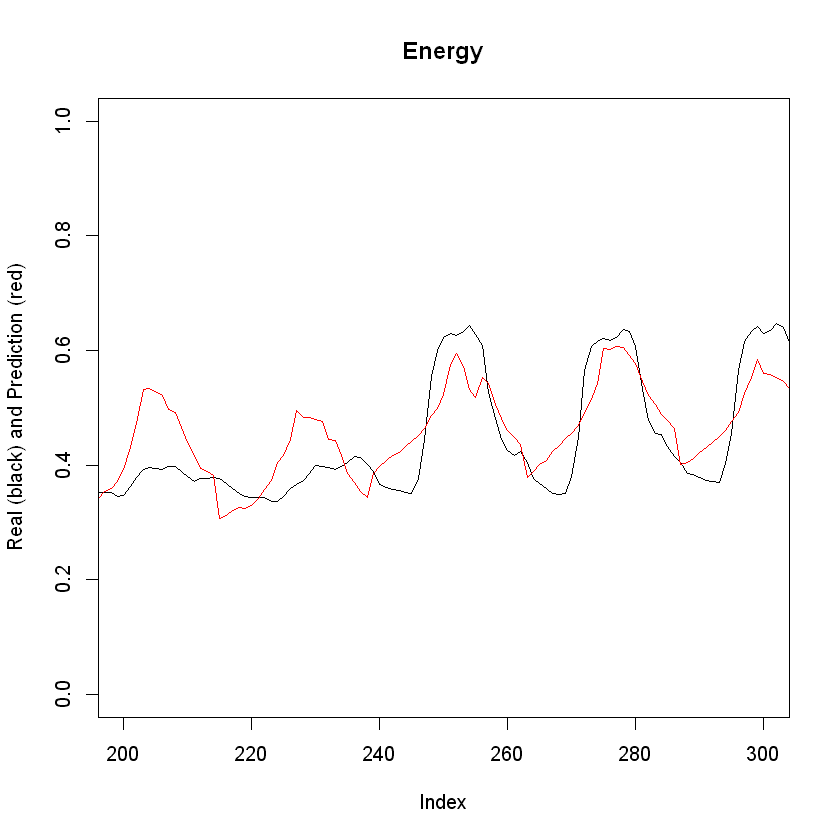

In [118]:
building_energy <- cbind(building_data, mydata$Energy)
nepochs = 100
adaline_energy = train_adaline(data=data.matrix(building_energy),
             eta = 0.001,
             tol = 0.0001,
             nepochs = nepochs)

results_energy <- evaluate_adaline(adaline_energy, building_energy)
plot(1:nepochs, adaline_energy$errors, 'l', main="Energy Error", xlab="Epoch", ylab="Mean Squared Error")
xlimplot=c(200,300)
ylimplot=c(0,1)
plot(mydata$Energy, type='l', xlim=xlimplot, ylim=ylimplot, ylab="")
par(new=T)
plot(results_energy$yhat, col="red", type='l', xlim=xlimplot, ylim=ylimplot, main="Energy", ylab="Real (black) and Prediction (red)")

Erro quadrático médio obtido:

In [119]:
results_energy$mse

[1] 0.004825963

#### 2) Hot Water

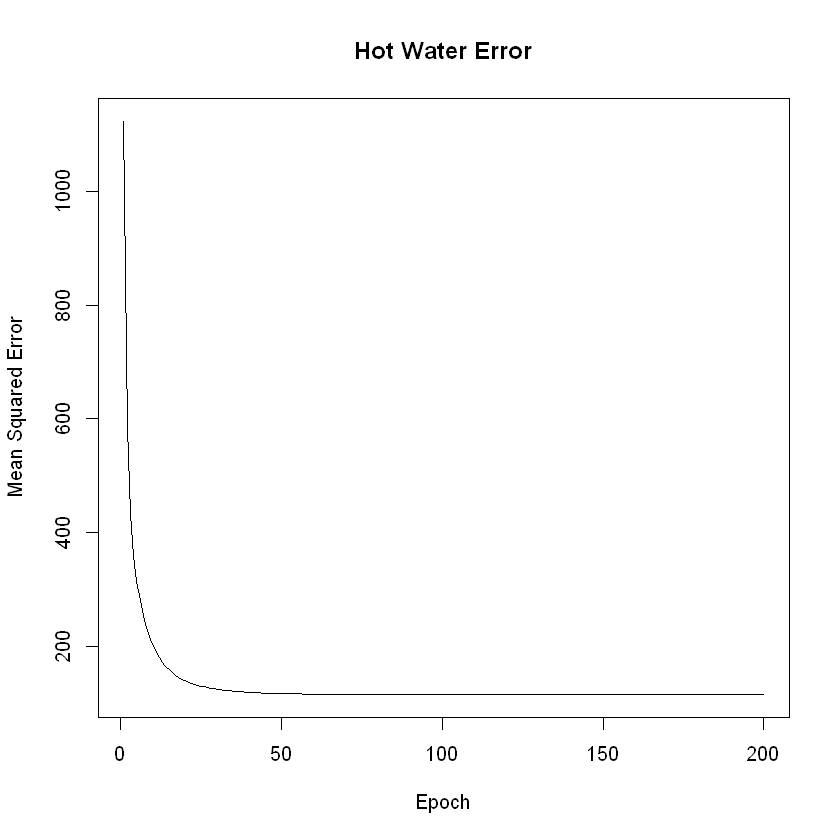

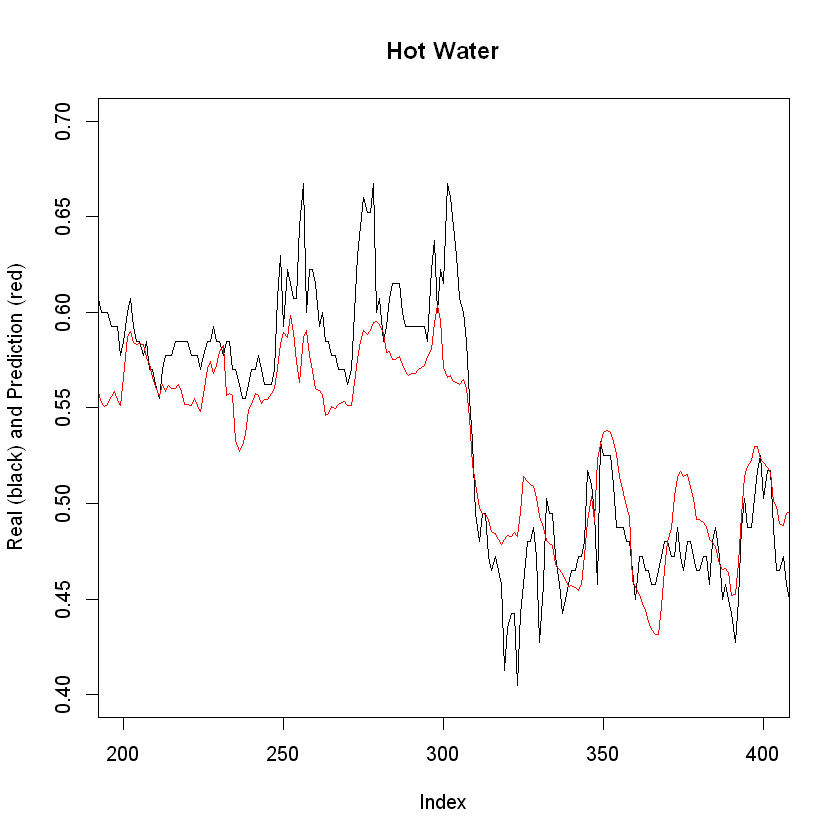

In [120]:
building_hot <- cbind(building_data, mydata$Hot_Water)
nepochs = 200
adaline_hot = train_adaline(data=data.matrix(building_hot),
             eta = 0.002,
             tol = 0.0001,
             nepochs = nepochs)
results_hot <- evaluate_adaline(adaline_hot, building_hot)
plot(1:nepochs, adaline_hot$errors, 'l', main="Hot Water Error", xlab="Epoch", ylab="Mean Squared Error")
xlimplot=c(200,400)
ylimplot=c(0.4,0.7)
plot(mydata$Hot_Water, type='l', xlim=xlimplot, ylim=ylimplot, ylab="")
par(new=T)
plot(results_hot$yhat, col="red", type='l', xlim=xlimplot, ylim=ylimplot, main="Hot Water", ylab="Real (black) and Prediction (red)")

Erro quadrático médio obtido:

In [121]:
results_hot$mse

[1] 0.001492091

#### 3) Cold Water

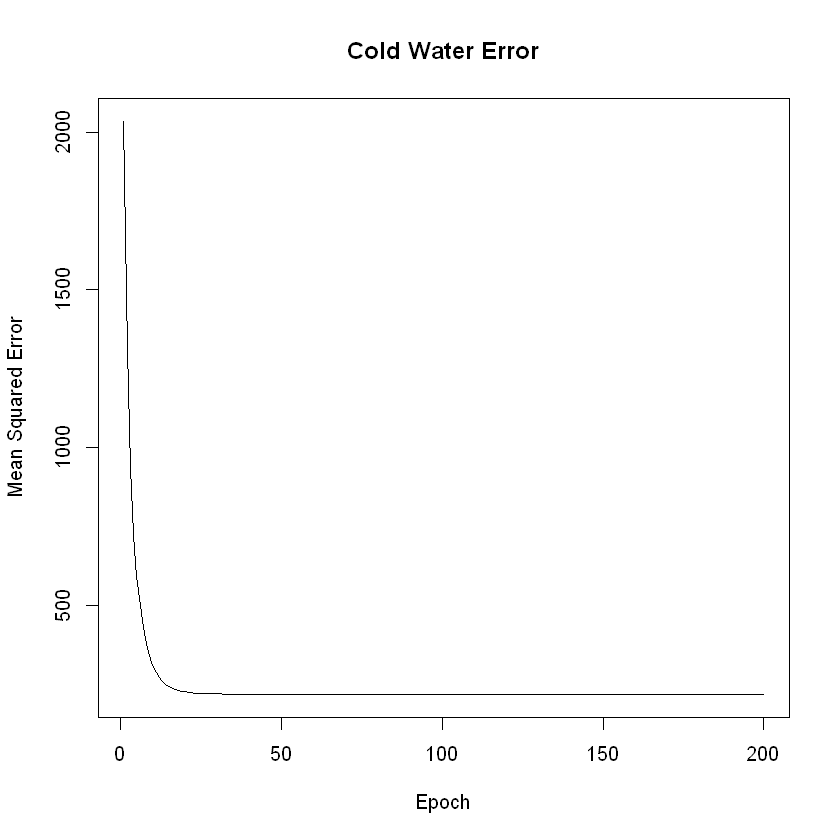

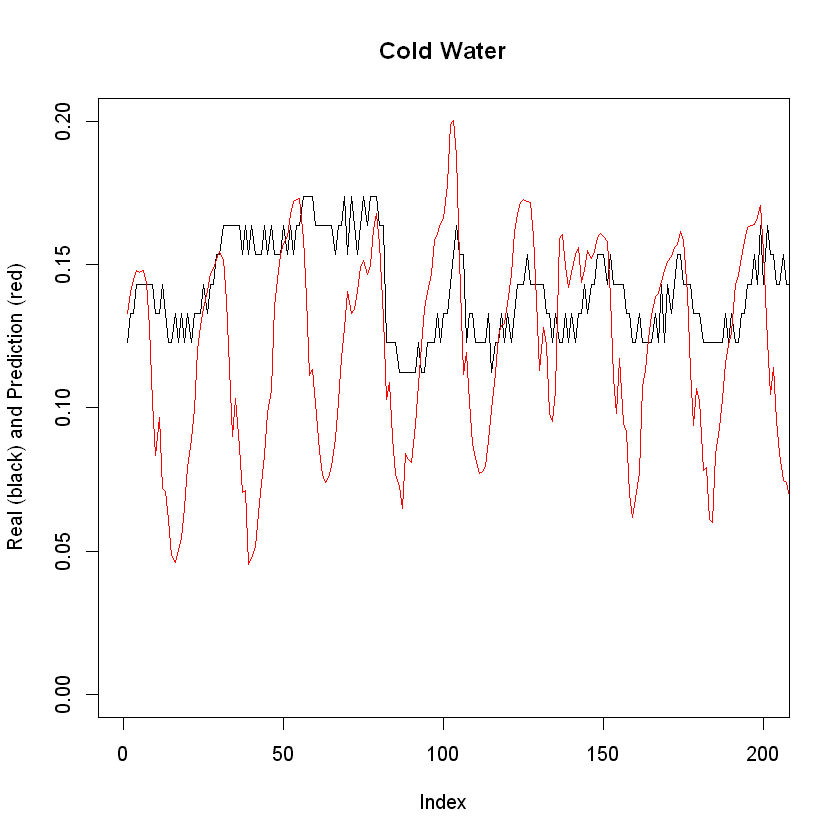

In [124]:
building_cold <- cbind(building_data, mydata$Cold_Water)
nepochs = 200
adaline_cold <- train_adaline(data=data.matrix(building_cold),
             eta = 0.001,
             tol = 0.00001,
             nepochs = nepochs)
plot(1:nepochs, adaline_cold$errors, 'l', main="Cold Water Error", xlab="Epoch", ylab="Mean Squared Error")
results_cold <- evaluate_adaline(adaline_cold, building_cold)
xlimplot=c(0,200)
ylimplot=c(0,0.2)
plot(mydata$Cold_Water, type='l', xlim=xlimplot, ylim=ylimplot, ylab="")
par(new=T)
plot(results_cold$yhat, col="red", type='l', xlim=xlimplot, ylim=ylimplot, main="Cold Water", ylab="Real (black) and Prediction (red)")

Erro quadrático médio obtido:

In [125]:
results_cold$mse

[1] 0.004018722